metrics to compare:
- speed in ms per delta t timestep (fine solver vs end to end) -> scale that to big resolution and say we save x amount of time
- MSE, MAE for each snapshot
- generalization (marmousi and bp dataset, but then own, easier velocities)

In [4]:
from generate_data import wave_util
import torch
import numpy as np
import matplotlib.pyplot as plt
from models import model_end_to_end
from skimage.transform import resize
from models.model_utils import fetch_data_end_to_end
from generate_data.wave_propagation import velocity_verlet_tensor, pseudo_spectral, velocity_verlet
from models.model_utils import get_paths, get_params
import torch.nn.functional as F

In [5]:
#params
param_dict = get_params("0")
batch_size, lr, res_scaler, n_epochs, model_name, Nx, flipping, boundary_c, delta_t_star, f_delta_x = \
        param_dict["batch_size"], param_dict["lr"], param_dict["res_scaler"], param_dict["n_epochs"],param_dict["model_name"],param_dict["model_res"],param_dict["flipping"],param_dict["boundary_c"],param_dict["delta_t_star"],param_dict["f_delta_x"]
n_snaps = param_dict["n_snaps"]
dt = param_dict["f_delta_t"]
f_delta_t = param_dict["f_delta_t"]
dx = param_dict["f_delta_x"]
dT = param_dict["c_delta_t"]
dX = param_dict["c_delta_x"]
c_Nx = c_Ny = int(Nx) // int(res_scaler)

data_paths, train_logger_path, valid_logger_path, dir_path_save, _ = get_paths()
loaders = fetch_data_end_to_end(data_paths, shuffle=True, batch_size=1)

param settings: batch_size: 1, lr: 0.001, res_scaler: 2, n_epochs: 500, model_name: end_to_end_only_unet3lvl, model_res: 128, coarse_res: 64.0, n_snaps: 11, flipping: False, boundary_c: absorbing, total_time: 0.6, delta_t_star: 0.06, f_delta_x: 0.015625, f_delta_t: 0.00078125, c_delta_x: 0.03125, c_delta_t: 0.0026041666666666665
test data points: 10


In [3]:
# set up models

restr_model1 = model_end_to_end.Restriction_nn(param_dict = param_dict).double()
restr_model1 = torch.nn.DataParallel(restr_model1)
restr_model1.load_state_dict(torch.load('../results/run_2/1/saved_model_end_to_end_only_unet3lvl128_9.pt'))

netlist = [
    (r'end-to-end unet 3lvl', restr_model1),
]

for netname,netmodl in netlist:
    model_parameters = filter(lambda p: p.requires_grad, netmodl.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(netname,'number of trainable parameters', params)

RuntimeError: Error(s) in loading state_dict for DataParallel:
	size mismatch for module.phys_comp_restr_layer1.restr.0.weight: copying a param with shape torch.Size([4, 2, 3, 3]) from checkpoint, the shape in current model is torch.Size([4, 1, 3, 3]).
	size mismatch for module.phys_comp_restr_layer2.restr.0.weight: copying a param with shape torch.Size([8, 4, 3, 3]) from checkpoint, the shape in current model is torch.Size([8, 2, 3, 3]).
	size mismatch for module.phys_comp_restr_layer3.restr.0.weight: copying a param with shape torch.Size([8, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([8, 4, 3, 3]).
	size mismatch for module.phys_comp_restr_layer4.restr.0.weight: copying a param with shape torch.Size([16, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 4, 3, 3]).
	size mismatch for module.phys_comp_restr_layer5.restr.0.weight: copying a param with shape torch.Size([16, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 8, 3, 3]).
	size mismatch for module.phys_comp_restr_layer6.restr.0.weight: copying a param with shape torch.Size([8, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([8, 8, 3, 3]).
	size mismatch for module.phys_comp_restr_layer7.restr.0.weight: copying a param with shape torch.Size([4, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([4, 4, 3, 3]).
	size mismatch for module.phys_comp_restr_layer8.restr.0.weight: copying a param with shape torch.Size([2, 4, 3, 3]) from checkpoint, the shape in current model is torch.Size([2, 2, 3, 3]).
	size mismatch for module.vel_restr_layer8.restr.0.weight: copying a param with shape torch.Size([2, 2, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 2, 3, 3]).
	size mismatch for module.vel_restr_layer8.restr.0.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([1]).

In [6]:
x = np.arange(-1,1,dx)
y = np.arange(-1,1,dx)
xx,yy = np.meshgrid(x,y)

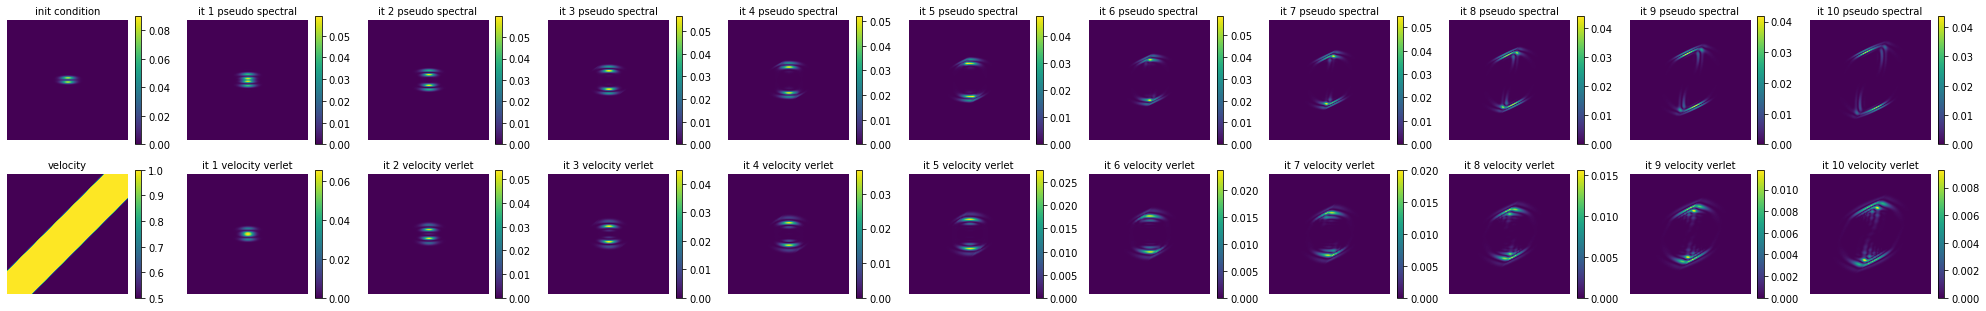

In [7]:
uc, utc = np.zeros([n_snaps-1,Nx,Nx]), np.zeros([n_snaps-1,Nx,Nx])
uf, utf = np.zeros([n_snaps-1,Nx,Nx]), np.zeros([n_snaps-1,Nx,Nx])
uo, uto = np.zeros([n_snaps-1,Nx,Nx]), np.zeros([n_snaps-1,Nx,Nx])

with torch.no_grad():
    for loader in loaders:
        for i, data in enumerate(loader):

            input = data[0].squeeze() # n_snaps x 4 x w x h
            fig = plt.figure(figsize=(35,8))

            #initial condition visualization
            vel = torch.from_numpy(1. + 0.0*yy - 0.5*(np.abs(yy+xx-0.)>0.4) + 0.*(np.abs(xx-0.4)<0.2)*(np.abs(yy-0.5)<0.1))
            #vel = input[0, 3, :, :]#torch.from_numpy()
            vel_c = resize(vel, [64,64], order=4)
            vel_c = torch.from_numpy(vel_c)
            center = np.array([0.,0.])
            u0 = torch.from_numpy(np.exp(-250.0*(0.2*(xx-center[0])**2 + (yy-center[1])**2))*np.cos(8*np.pi*(yy-center[1])))
            ut0 = torch.from_numpy(np.zeros([np.size(xx,axis=1),np.size(yy,axis=0)]))
            u_x, u_y, u_t_c = wave_util.WaveEnergyComponentField_tensor(u0.unsqueeze(dim=0), ut0.unsqueeze(dim=0), vel.unsqueeze(dim=0),f_delta_x)
            #u_x, u_y, u_t_c = input[0, 0, :, :], input[0, 1, :, :], input[0, 2, :, :]
            sumv = torch.sum(torch.sum(u_x))
            u, ut = wave_util.WaveSol_from_EnergyComponent_tensor(u_x, u_y, u_t_c, vel.unsqueeze(dim=0), f_delta_x, sumv)

            axi = fig.add_subplot(3,11,1)
            posi = axi.imshow(wave_util.WaveEnergyField_tensor(u.squeeze(),ut.squeeze(),vel,f_delta_x)*f_delta_x*f_delta_x)
            axi.set_title('init condition', fontsize=10)
            plt.colorbar(posi)
            plt.axis('off')

            # velocity visualization
            axv = fig.add_subplot(3,11,12)
            posv = axv.imshow(vel)
            plt.colorbar(posv)
            axv.set_title('velocity', fontsize=10)
            plt.axis('off')

            # # fine solver iteration
            # for j in range(1,input.shape[0]-1):
            #     u_x, u_y, u_t_c = input[j, 0, :, :], input[j, 1, :, :], input[j, 2, :, :]  # w x h
            #     sumv = torch.sum(torch.sum(u_x))
            #     u, ut = wave_util.WaveSol_from_EnergyComponent_tensor(u_x.unsqueeze(dim=0), u_y.unsqueeze(dim=0), u_t_c.unsqueeze(dim=0), vel.unsqueeze(dim=0), f_delta_x, sumv)
            #     uf[j-1,:,:],utf[j-1,:,:] = u.squeeze(), ut.squeeze()
            #     ax = fig.add_subplot(3,11,1+j)
            #     pos = ax.imshow(wave_util.WaveEnergyField_tensor(u.squeeze(),ut.squeeze(),vel,f_delta_x)*f_delta_x*f_delta_x)
            #     ax.set_title('it '+str(j)+' pseudo spectral', fontsize=10)
            #     plt.colorbar(pos)
            #     plt.axis('off')

            ufx, ufcx = u.clone(), ut.clone()
            vel_numpy = vel.numpy()
            for j in range(1,input.shape[0]-1):
                if j == 1: ufx, ufcx = ufx.squeeze().numpy(), ufcx.squeeze().numpy()
                ufx, ufcx = pseudo_spectral(ufx, ufcx, vel_numpy, dx, dt, delta_t_star)#, number=1, boundary_c="absorbing")#boundary_c)
                ax = fig.add_subplot(3,11,1+j)
                pos = ax.imshow(wave_util.WaveEnergyField(ufx,ufcx,vel_numpy,f_delta_x)*f_delta_x*f_delta_x)
                ax.set_title('it '+str(j)+' pseudo spectral', fontsize=10)
                plt.colorbar(pos)
                plt.axis('off')

            # coarse solver
            ucx, utcx = u.clone(), ut.clone()
            ucx, utcx = ucx.squeeze(), utcx.squeeze()
            for j in range(1,input.shape[0]-1):
                ucx, utcx = torch.from_numpy(resize(ucx, [c_Nx,c_Nx], order=4)), torch.from_numpy(resize(utcx, [c_Nx,c_Nx], order=4))
                ucx, utcx = velocity_verlet_tensor(
                    ucx.unsqueeze(dim=0), utcx.unsqueeze(dim=0),
                    vel_c.unsqueeze(dim=0), dX, dT, delta_t_star, number=1, boundary_c=boundary_c
                )
                ucx, utcx = ucx.squeeze(), utcx.squeeze()
                ucx, utcx = torch.from_numpy(resize(ucx, [Nx,Nx], order=4)), torch.from_numpy(resize(utcx, [Nx,Nx], order=4))
                uc[j-1,:,:],utc[j-1,:,:]  = ucx, utcx
                ax2 = fig.add_subplot(3,11,12+j)
                ax2.set_title('it '+str(j)+' velocity verlet', fontsize=10)
                pos2 = ax2.imshow(wave_util.WaveEnergyField_tensor(ucx, utcx, vel, dx) * dx * dx)
                plt.colorbar(pos2)
                plt.axis('off')

            # #end to end
            # u_x_e, u_y_e, u_t_c_e = u_x.clone(), u_y.clone(), u_t_c.clone()
            # for j in range(1,input.shape[0]-1):
            #     input_model = torch.stack([u_x_e, u_y_e, u_t_c_e, vel.unsqueeze(dim=0)],dim=1)
            #     output = restr_model1(input_model)  # b x 3 x w x h
            #     u_x_e, u_y_e, u_t_c_e = output[:,0, :, :].clone(), output[:,1, :, :].clone(), output[:,2, :,:].clone()
            #     sumv = torch.sum(torch.sum(u_x_e))
            #     u_e, ut_e = wave_util.WaveSol_from_EnergyComponent_tensor(u_x_e, u_y_e, u_t_c_e, vel, f_delta_x, sumv)
            #
            #     uo[j-1,:,:], uto[j-1,:,:] = u_e.squeeze(), ut_e.squeeze()
            #     ax3 = fig.add_subplot(3,11,23+j)
            #     pos3 = ax3.imshow(wave_util.WaveEnergyField_tensor(u_e.squeeze(), ut_e.squeeze(), vel, f_delta_x) * f_delta_x * f_delta_x)
            #     ax3.set_title('it ' + str(j) + ' end to end', fontsize=10)
            #     plt.colorbar(pos3)
            #     plt.axis('off')

            break
        break

In [21]:
# compare wave energy norm errors:

from sklearn.metrics import mean_squared_error, mean_absolute_error
from tabulate import tabulate

table = [["snapshot", "MSE coarse", "MSE end to end", "MAE coarse", "MAE end to end"]]

for it in range(0,10):
    wf = wave_util.WaveEnergyField(uf[it,:,:], utf[it,:,:], vel.numpy(), f_delta_x)*f_delta_x*f_delta_x
    w1 = wave_util.WaveEnergyField(uc[it,:,:], utc[it,:,:], vel.numpy(), f_delta_x)*f_delta_x*f_delta_x
    w2 = wave_util.WaveEnergyField(uo[it,:,:], uto[it,:,:], vel.numpy(), f_delta_x)*f_delta_x*f_delta_x

    mse1 = mean_squared_error(wf, w1)
    mse2 = mean_squared_error(wf, w2)

    mae1 = mean_absolute_error(wf, w1)
    mae2 = mean_absolute_error(wf, w2)

    table.append([it, mse1, mse2, mae1,mae2])

print("compare fine solver result to implementation:")
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

compare fine solver result to implementation:
╒════════════╤══════════════╤══════════════════╤══════════════╤══════════════════╕
│   snapshot │   MSE coarse │   MSE end to end │   MAE coarse │   MAE end to end │
╞════════════╪══════════════╪══════════════════╪══════════════╪══════════════════╡
│          0 │  7.34363e-07 │      1.14674e-07 │  0.000126625 │      4.94801e-05 │
├────────────┼──────────────┼──────────────────┼──────────────┼──────────────────┤
│          1 │  5.90717e-07 │      1.07917e-07 │  0.000183858 │      7.31814e-05 │
├────────────┼──────────────┼──────────────────┼──────────────┼──────────────────┤
│          2 │  4.6535e-07  │      1.08346e-07 │  0.000207308 │      8.78103e-05 │
├────────────┼──────────────┼──────────────────┼──────────────┼──────────────────┤
│          3 │  4.08329e-07 │      1.1793e-07  │  0.000217532 │      9.42303e-05 │
├────────────┼──────────────┼──────────────────┼──────────────┼──────────────────┤
│          4 │  2.37913e-07 │      7.8374